<div style="display:flex">
    <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="Logo 1">
</div>

# Traffic Signs Detection

## Table of Contents
1. **[Part 1: Data preparation](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Image and Label Structure 
   - 1.3. Class Distribution Analysis

2. **[Part 2: Few-Shot Training](#part2)**
   - 2.1 Few-Shot Dataset Creation
   - 2.2 Model 1: Binary Cross Entropy Loss
   - 2.3 Model 2: Focal Loss

3. **[Full Dataset Training??](#part3)**
   - 3.1 ...

   


### Install and Import libraries

In [1]:
!pip install ultralytics

In [2]:
# Importing Libraries
import os
import cv2
import glob
import shutil
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='darkgrid')
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Video

from tqdm.notebook import trange, tqdm

import yaml
from ultralytics import YOLO

import warnings
warnings.filterwarnings('ignore')

# Setting the random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Part 1: Data Preparation <a id="part1"></a>

To investigate the dataset, we will first check that there are no mismatches between images and labels, then understand how the labelling system works and how its paired to the images, and visualize some examples.  Additionally, we can check the classes distribution

### Utilities functions

In [3]:
# Function to display an image with its bounding boxes
def display_image_with_boxes(image_path, label_file, include_label=True):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the label file
    with open(label_file, 'r') as file:
        labels = file.readlines()

    # Draw bounding boxes on the image
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert YOLO format to pixel coordinates
        img_height, img_width, _ = image.shape
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put class ID text
        if include_label:
            cv2.putText(image, class_names[str(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show() 

In [4]:
# Function to get the label file path from the image path
def get_label_file(image_path):
    # Replace 'images' with 'labels' in the path
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    return label_path

In [5]:
# Set the directory paths
path= os.getcwd()
Image_dir = os.path.join(path, 'data', 'train', 'images')
image_files = os.listdir(Image_dir)

Understand how labels are structured and paired with images

Labels for FisheyeCamera_1_00076_png.rf.c1649fd1ef9e95ffa77a31dcffb825ed.jpg:
0 0.3641826923076923 0.41346153846153844 0.015625 0.009615384615384616
7 0.36778846153846156 0.5456730769230769 0.006009615384615385 0.008413461538461538
1 0.4495192307692308 0.5024038461538461 0.006009615384615385 0.003605769230769231


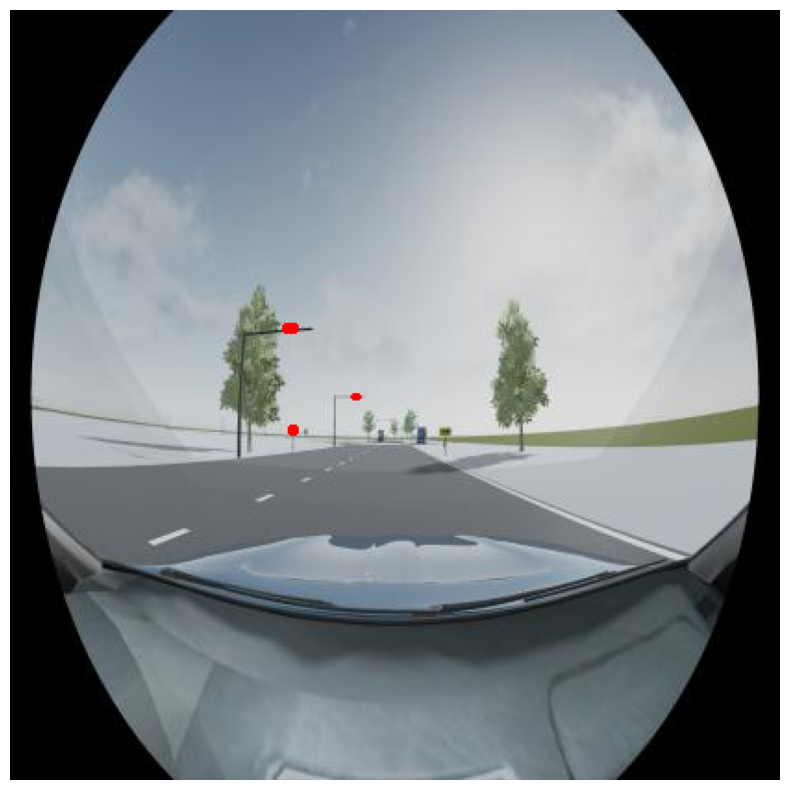

In [6]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")
# Display a random image with its bounding boxes

display_image_with_boxes(random_image_path, label_file, include_label=False)


As we can observe, labels are not in natural languange, but rather encoded in an intengers list. Let's further investigate on that, and create a dictionary the class numbers (6) to natural language labels (speed limit 20), using the information on the kaggle dataset

In [7]:
# get a set of all image labels (only the number of the class)
labels = set()
for image in image_files:
    label_file = get_label_file(os.path.join(Image_dir, image))
    if os.path.exists(label_file):
        with open(label_file, 'r') as file:
            for line in file:
                class_id = line.strip().split()[0]
                labels.add(class_id)

# Convert the set to a sorted list
labels = sorted(labels)
# Display the unique labels
print(f"Unique labels found in the dataset: {labels}")


Unique labels found in the dataset: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
# create a dictionary to map class IDs to class names
class_names = {
    '0': 'Green Light',
    '1': 'Red Light',
    '2': 'Speed Limit 10',  
    '3': 'Speed Limit 100',
    '4': 'Speed Limit 110',
    '5': 'Speed Limit 120',
    '6': 'Speed Limit 20',
    '7': 'Speed Limit 30',
    '8': 'Speed Limit 40',
    '9': 'Speed Limit 50',
    '10': 'Speed Limit 60',
    '11': 'Speed Limit 70',
    '12': 'Speed Limit 80',
    '13': 'Speed Limit 90',
    '14': 'Stop'}

Let's now verify that these label names are correct (we can re run the following code chunk multiple times to assert this)

Labels for 00002_00017_00008_png.rf.958d92ad47742185bf2850483fb42da9.jpg:
9 0.5120192307692307 0.4795673076923077 0.6177884615384616 0.6430288461538461


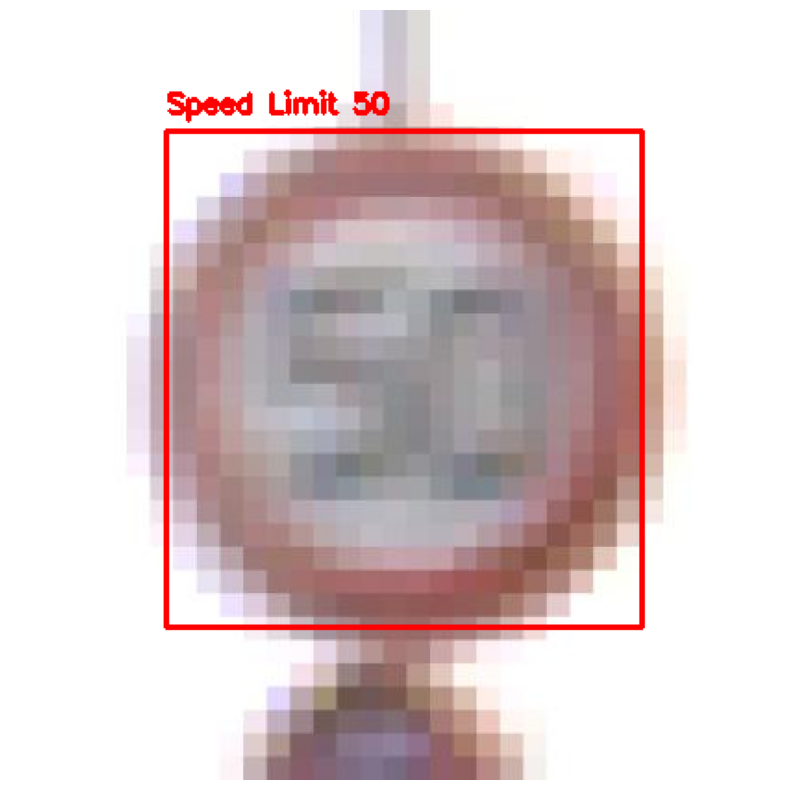

In [9]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")


# Display a random image with its bounding boxes
display_image_with_boxes(random_image_path, label_file)

Look for mismatches

In [10]:
# Count total amount of train, val and test images (+ labels)
train_images = os.listdir(Image_dir)
train_labels = os.listdir(os.path.join(path, 'data', 'train', 'labels'))
print(f'Total number of training images: {len(train_images)}')
print(f'Total number of training labels: {len(train_labels)}\n')

val_images = os.listdir(os.path.join(path, 'data', 'valid', 'images'))
val_labels = os.listdir(os.path.join(path, 'data', 'valid', 'labels'))
print(f'Total number of validation images: {len(val_images)}')    
print(f'Total number of validation labels: {len(val_labels)}\n')   

test_images = os.listdir(os.path.join(path, 'data', 'test', 'images'))
test_labels = os.listdir(os.path.join(path, 'data', 'test', 'labels'))
print(f'Total number of test images: {len(test_images)}')
print(f'Total number of test labels: {len(test_labels)}')

Total number of training images: 3530
Total number of training labels: 3530

Total number of validation images: 801
Total number of validation labels: 801

Total number of test images: 638
Total number of test labels: 638


Check Image shape

In [11]:
# Get the size of a random image
random_image_path = os.path.join(Image_dir, random.choice(image_files))

# Load the image
image = cv2.imread(random_image_path)

# Get the size of the image
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


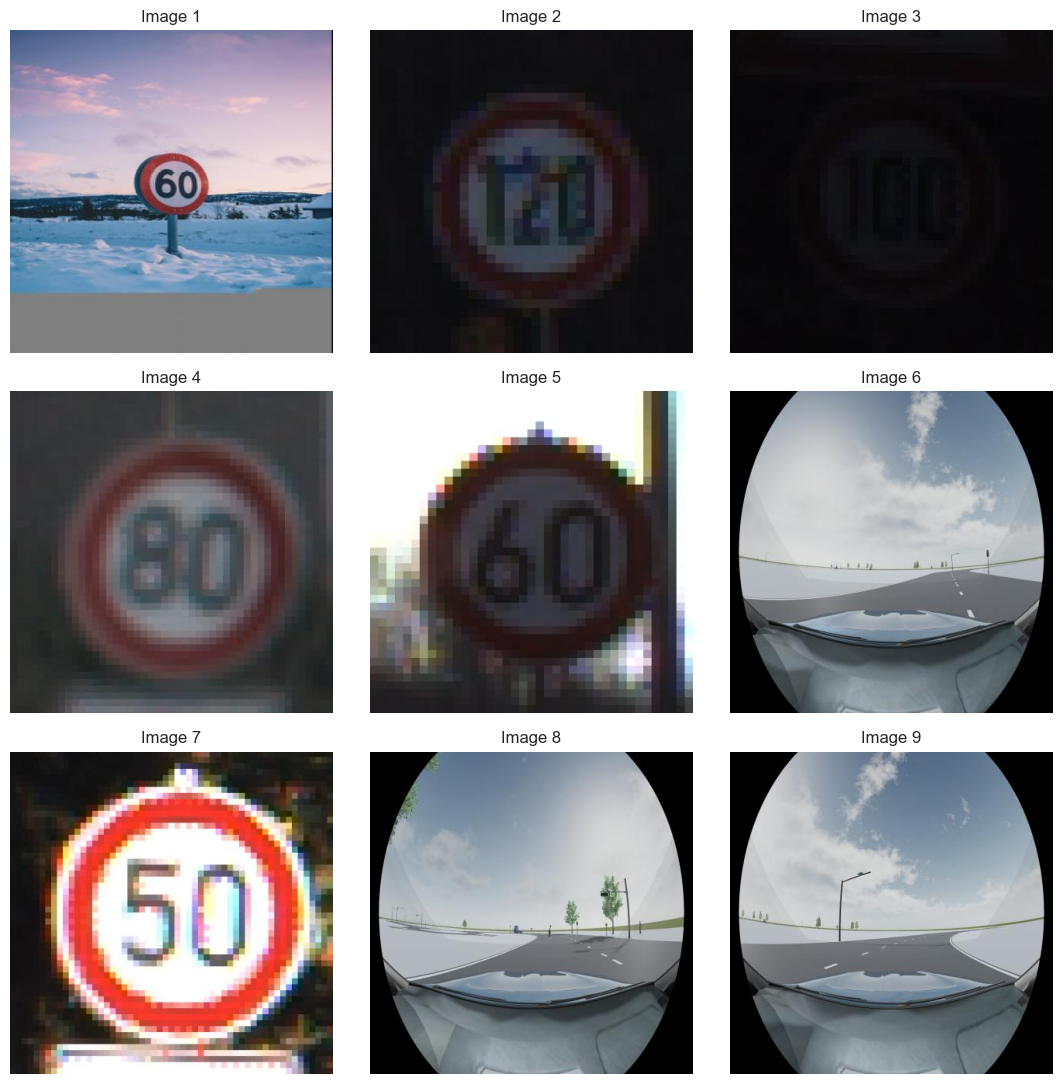

In [12]:
num_samples = 9

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Looking good! Now we have a pretty good idea of how the images are structured. Let's look at the image distribution before we can move on to training end evaluating our models 

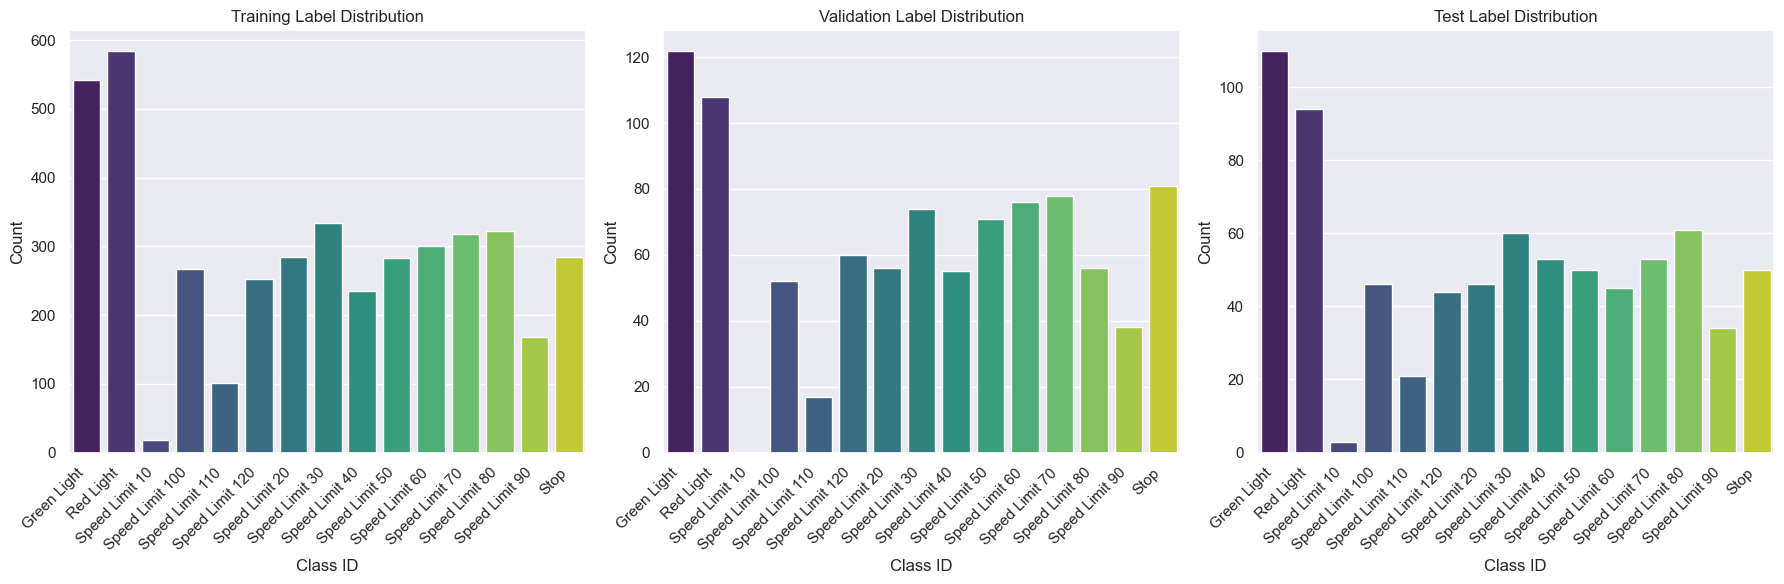

In [13]:

# train
train_label_counts = {label: 0 for label in class_names.values()} 
for label_file in train_labels:
    with open(os.path.join(path, 'data', 'train', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            train_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
train_label_counts_df = pd.DataFrame(list(train_label_counts.items()), columns=['Class ID', 'Count'])

# Validation
val_label_counts = {label: 0 for label in class_names.values()}
for label_file in val_labels:
    with open(os.path.join(path, 'data', 'valid', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            val_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
val_label_counts_df = pd.DataFrame(list(val_label_counts.items()), columns=['Class ID', 'Count'])   

# Test
test_label_counts = {label: 0 for label in class_names.values()}
for label_file in test_labels:
    with open(os.path.join(path, 'data', 'test', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            test_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
test_label_counts_df = pd.DataFrame(list(test_label_counts.items()), columns=['Class ID', 'Count'])


# Create three subplots for train, validation, and test label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, df, title in zip(axes,
                         [train_label_counts_df, val_label_counts_df, test_label_counts_df],
                         ['Training', 'Validation', 'Test']):
    sns.barplot(x='Class ID', y='Count', data=df, ax=ax, palette='viridis')
    ax.set_title(f'{title} Label Distribution')
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Count')
    # rotate the labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

We can observe some very dispare class distribution, yet there is some sort of consistency across the different datasets (train, val, test). Below are a few considerations:
- Given the extreme class imbalance of Speed Limit 10, we decide to drop it. We will however keep Speed Limit 110 as it is a significantly imbalanced class which can perhaps help deliver a valuable Error Analysis later. 
- To tackle the class imbalance, we could **switch the classification head to Focal Loss**, which is a provided option for YOLOv8. 
- It is also interesting to allow for class-specific confidence thresholds at inference time, to further account for the class imbalance. 

## Part 1: Few-Shot Training <a id="part2"></a>

### 2.1 Few-Shot Dataset Creation

In [14]:
# !pip install --upgrade ultralytics ray

Let's create the dataset used for the few-show training of our YOLOv8 classification model. To do so, here are a few considerations to bear in mind in the design:
- We keep the same (approx.) distribution of labels as in the full train dataset, excluding the `Speed Limit 10` label. 
- When selecting the images, we use those that have only the specific class we are looking for (no multi-label images)

In [15]:
# Define paths again
Image_dir = os.path.join(path, 'data', 'train', 'images')
train_labels = os.listdir(os.path.join(path, 'data', 'train', 'labels'))


# Create a new directory for the few-shot dataset
few_shot_data_dir = os.path.join(path, 'data', 'few_shot')
few_shot_img_dir  = os.path.join(few_shot_data_dir, 'images')
few_shot_lbl_dir  = os.path.join(few_shot_data_dir, 'labels')
os.makedirs(few_shot_img_dir, exist_ok=True)
os.makedirs(few_shot_lbl_dir, exist_ok=True)

# Function to copy a specified number of images for each class
def copy_few_shot_images(class_id, num_images):
    
    matching = []
    for lf in train_labels:
        lbl_path = os.path.join(path, 'data', 'train', 'labels', lf)
        with open(lbl_path) as f:       
            lines = [line.strip() for line in f if line.strip()] # Read and strip out any blank lines            
            if lines and all(line.split()[0] == class_id for line in lines):
                matching.append(lf) # Keep only files that have at least one box, and all boxes are of this class

    if len(matching) < num_images:
        print(f"Not enough for class {class_id}: found {len(matching)}")
        return

    for lf in random.sample(matching, num_images):
        img_name = lf.replace('.txt', '.jpg')
        shutil.copy(
            os.path.join(Image_dir, img_name),
            os.path.join(few_shot_img_dir, img_name)
        )
        shutil.copy(
            os.path.join(path, 'data', 'train', 'labels', lf),
            os.path.join(few_shot_lbl_dir, lf)
        )

In [16]:
# Class distribution for few-shot learning
few_shot_counts = {
    '0': 20,
    '1': 20,
    '3': 11,
    '4': 4,
    '5': 10,
    '6': 11,
    '7': 13,
    '8': 9,
    '9': 11,
    '10': 12,
    '11': 13,
    '12': 13,
    '13': 7,
    '14': 11,
}


# copy examples, skipping '2'
for class_id, count in few_shot_counts.items():
    copy_few_shot_images(class_id, count)

print("Total few-shot images:", len(os.listdir(few_shot_img_dir)))

Total few-shot images: 225


Note that before training, we need to create a .yaml file. This a custom ultralytics YOLO dataset configuration in which we define the dataset root directory, relative paths to training and validation a a dictionary of class names

### 2.2 Model 1: Baseline Few-Shot

As a baseline, we fine-tuned a pretrained YOLOv8 model on our 10-shot-per-class dataset using no augmentation and default loss. This will serve as a practical lower bound for few-shot object detection.

In [17]:
# Build from YAML and transfer weights
baseline_model = YOLO('yolov8n.pt')  

cfg_path = os.path.join(os.getcwd(), 'data', 'few_shot_data.yaml')

# Train the Model !!
result_baseline = baseline_model.train(
    data=cfg_path,
    epochs=25,
    batch=16,
    optimizer='auto',
    name='few_shot_training_1', 
    mosaic=0.0,      # no mosaic augmentation
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # no HSV color jitter
    fliplr=0.0,      # no horizontal flips
    flipud=0.0       # no vertical flips
)

New https://pypi.org/project/ultralytics/8.3.156 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yol

2025-06-17 20:38:32,443	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\few_shot\labels.cache... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.0 ms, read: 43.934.6 MB/s, size: 20.7 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs\detect\few_shot_training_1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\few_shot_training_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.13G      1.383      5.341      1.615          2        640: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  3.21it/s]

                   all        801        944     0.0276     0.0186     0.0151     0.0142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.13G     0.9278      4.875      1.323          1        640: 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.81it/s]

                   all        801        944     0.0378      0.487     0.0618     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.14G     0.8813      4.245      1.285          1        640: 100%|██████████| 15/15 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  2.97it/s]

                   all        801        944     0.0172      0.699     0.0963     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.09G     0.8816      3.993      1.204          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.66it/s]


                   all        801        944     0.0107       0.74      0.123     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.08G     0.7724      3.816      1.134          1        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]


                   all        801        944      0.375      0.052      0.134      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.09G      0.758      3.758      1.141          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.03it/s]


                   all        801        944      0.297       0.12      0.171      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.08G     0.7631      3.494      1.077          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.02it/s]


                   all        801        944       0.23      0.303        0.2      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       2.1G     0.7091      3.427      1.044          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.06it/s]


                   all        801        944      0.269      0.467      0.235      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25       2.1G     0.7133      3.335      1.097          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.05it/s]


                   all        801        944      0.255      0.429       0.24      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25       2.1G     0.6801      3.132      1.089          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.12it/s]


                   all        801        944       0.29      0.433      0.282      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.09G     0.8167      3.199      1.057          2        640: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.26it/s]


                   all        801        944       0.34      0.465       0.32      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.1G     0.6376       2.89      1.022          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.15it/s]


                   all        801        944      0.368      0.433      0.351      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       2.1G     0.6702      2.853     0.9976          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.00it/s]


                   all        801        944      0.369      0.454      0.351      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       2.1G     0.6081      2.711     0.9881          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.03it/s]


                   all        801        944       0.42      0.451      0.411      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.09G     0.5736      2.545     0.9805          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.13it/s]


                   all        801        944       0.44      0.474      0.437      0.362
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       2.1G     0.5605      2.455     0.9638          1        640: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]


                   all        801        944      0.455      0.471      0.453      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       2.1G     0.5804      2.331      0.987          1        640: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.14it/s]


                   all        801        944      0.474      0.486      0.484      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       2.1G     0.5698      2.285      1.031          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.04it/s]


                   all        801        944      0.491      0.516      0.499      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.09G     0.5568      2.242      1.002          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.07it/s]


                   all        801        944      0.507      0.518      0.513       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25       2.1G     0.5615      2.181     0.9331          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.12it/s]


                   all        801        944       0.54      0.477      0.518      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       2.1G     0.5221      2.065     0.9298          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.19it/s]


                   all        801        944      0.548      0.487      0.532      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       2.1G     0.5102      2.006     0.9205          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]


                   all        801        944      0.611      0.487      0.551      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.09G     0.5183      1.916     0.9212          2        640: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.15it/s]


                   all        801        944      0.613      0.506       0.56      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       2.1G     0.5871      2.065     0.9661          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.12it/s]


                   all        801        944      0.599      0.519      0.564      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       2.1G     0.4973      2.084     0.9337          1        640: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.02it/s]


                   all        801        944      0.625      0.493      0.566      0.482

25 epochs completed in 0.130 hours.
Optimizer stripped from runs\detect\few_shot_training_1\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\few_shot_training_1\weights\best.pt, 6.3MB

Validating runs\detect\few_shot_training_1\weights\best.pt...
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:13<00:00,  1.98it/s]


                   all        801        944      0.627      0.493      0.566      0.482
           Green Light         87        122      0.663      0.287      0.401      0.239
             Red Light         74        108      0.771      0.342      0.473      0.271
       Speed Limit 100         52         52      0.478      0.404      0.448      0.411
       Speed Limit 110         17         17      0.314      0.235      0.269      0.245
       Speed Limit 120         60         60      0.699       0.65      0.686      0.611
        Speed Limit 20         56         56      0.648      0.786      0.803      0.671
        Speed Limit 30         71         74      0.515      0.474      0.484      0.442
        Speed Limit 40         53         55      0.621      0.582      0.648      0.553
        Speed Limit 50         68         71      0.781      0.493       0.69      0.607
        Speed Limit 60         76         76       0.71      0.658      0.742      0.665
        Speed Limit 7

In [19]:
results_training_fewshot = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","few_shot_training_1","results.csv"))
results_training_fewshot.tail(10)

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
15     16  305.543         0.56052         2.45488         0.96379   
16     17  323.136         0.58039         2.33059         0.98702   
17     18  341.624         0.56977         2.28453         1.03074   
18     19  360.161         0.55677         2.24246         1.00153   
19     20  378.530         0.56153         2.18123         0.93308   
20     21  396.097         0.52210         2.06499         0.92980   
21     22  413.481         0.51021         2.00598         0.92047   
22     23  431.232         0.51829         1.91642         0.92124   
23     24  449.025         0.58706         2.06525         0.96606   
24     25  467.772         0.49728         2.08436         0.93374   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
15               0.45487            0.47070           0.45290   
16               0.47391            0.48638           0.48384   
17               0.49102            0.51608           0.49875   
18               0.50736            0.51822           0.51278   
19               0.54008            0.47663           0.51819   
20               0.54751            0.48684           0.53246   
21               0.61104            0.48701           0.55054   
22               0.61285            0.50636           0.56016   
23               0.59939            0.51879           0.56372   
24               0.62452            0.49334           0.56562   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
15              0.37562       0.74326       1.76804       1.09419  0.000214   
16              0.40252       0.74742       1.68242       1.09805  0.000193   
17              0.41796       0.74231       1.62477       1.09638  0.000172   
18              0.43027       0.72902       1.60995       1.07781  0.000151   
19              0.43509       0.72773       1.63146       1.07199  0.000130   
20              0.44924       0.72908       1.59222       1.07177  0.000109   
21              0.46835       0.71913       1.55554       1.06230  0.000089   
22              0.47700       0.71533       1.52277       1.06255  0.000068   
23              0.48078       0.71501       1.50824       1.06176  0.000047   
24              0.48166       0.71352       1.50193       1.06062  0.000026   

      lr/pg1    lr/pg2  
15  0.000214  0.000214  
16  0.000193  0.000193  
17  0.000172  0.000172  
18  0.000151  0.000151  
19  0.000130  0.000130  
20  0.000109  0.000109  
21  0.000089  0.000089  
22  0.000068  0.000068  
23  0.000047  0.000047  
24  0.000026  0.000026

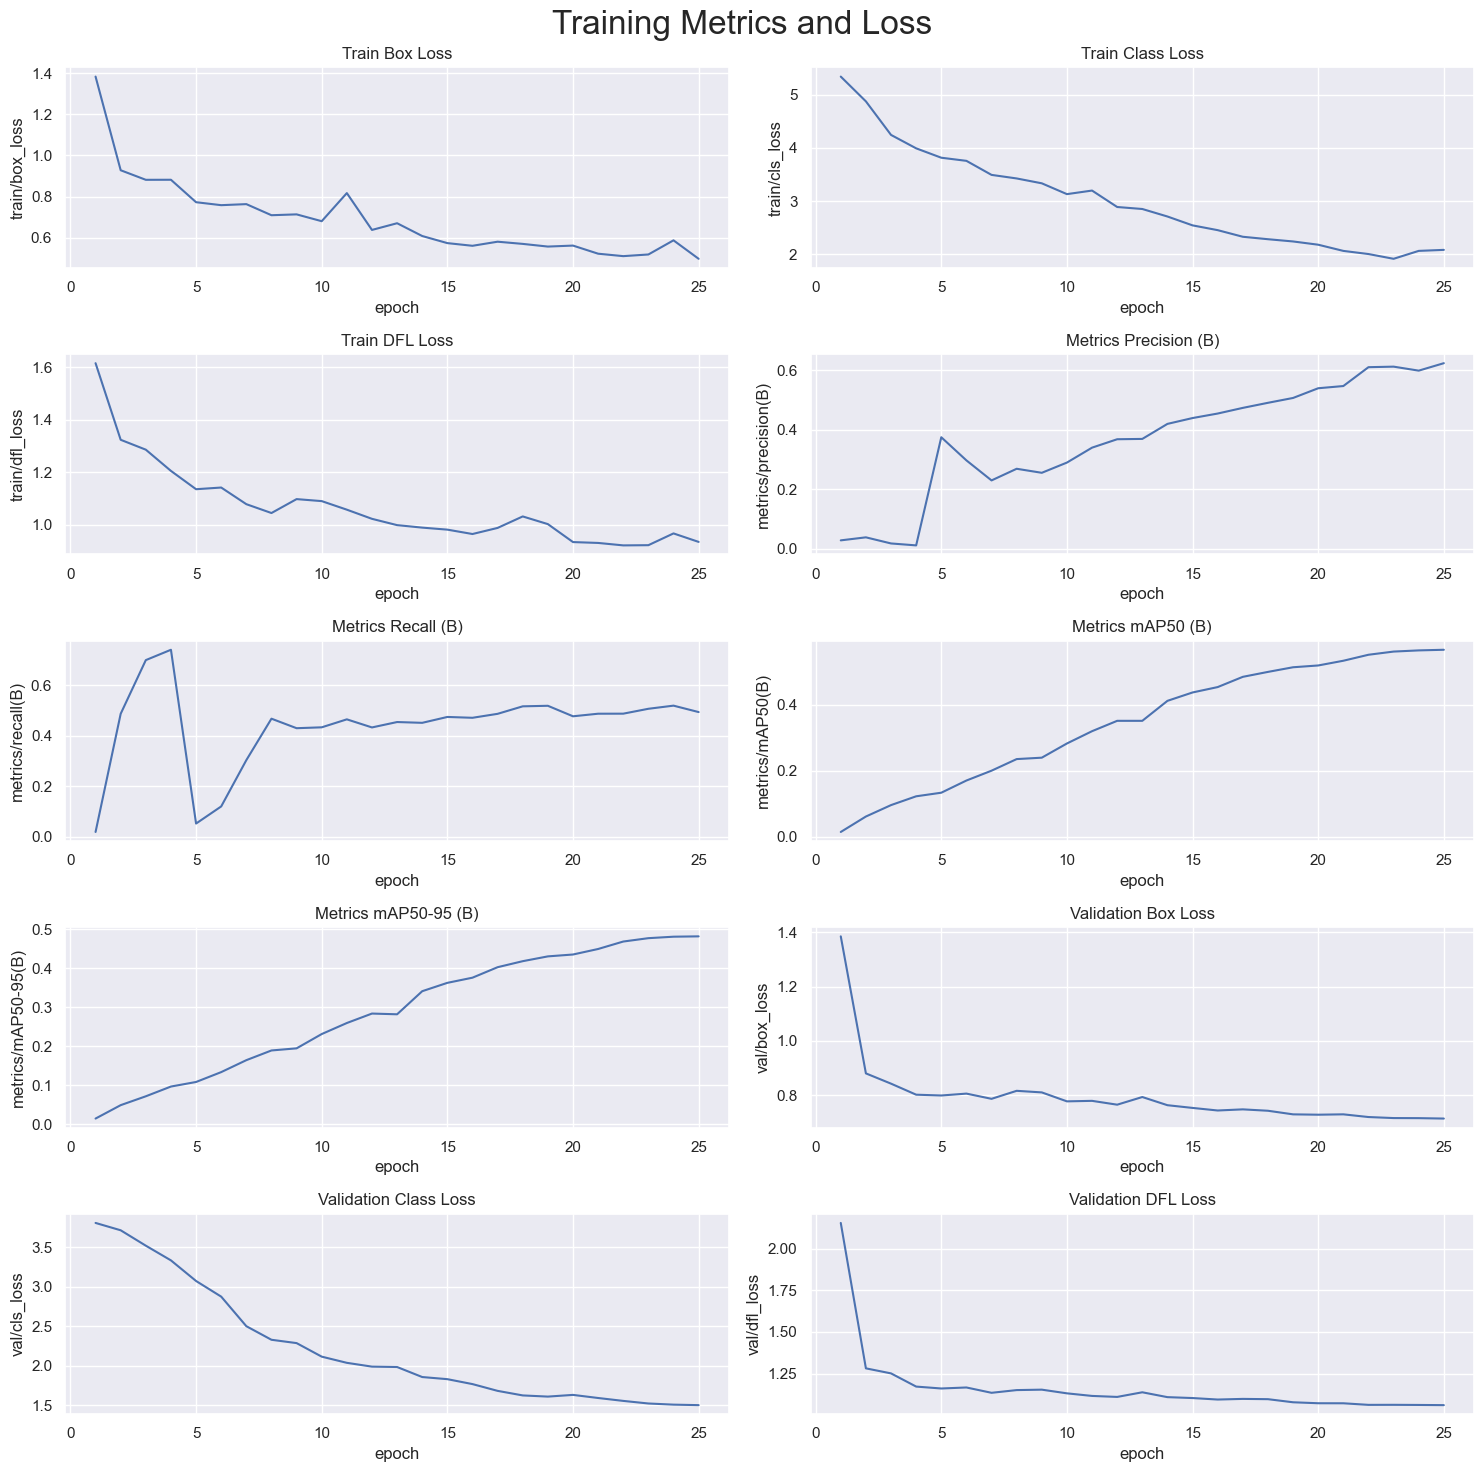

In [21]:
# Read the results.csv file as a pandas dataframe
results_training_fewshot.columns = results_training_fewshot.columns.str.strip()

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=results_training_fewshot, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=results_training_fewshot, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=results_training_fewshot, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=results_training_fewshot, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=results_training_fewshot, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=results_training_fewshot, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=results_training_fewshot, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=results_training_fewshot, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=results_training_fewshot, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=results_training_fewshot, ax=axs[4,1])

# Set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

## Model Validation

In [22]:
metrics = baseline_model.val(
    data=cfg_path,
    imgsz=416,
    batch=16,
    save=True,                # save images with boxes
    plots=True,               # save PR-curves, confusion matrix, etc.
    name='few_shot_val_1', 
    exist_ok=True             # overwrite if it already exists
)


Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 97.636.7 MB/s, size: 19.7 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:05<00:00,  9.10it/s]


                   all        801        944      0.551      0.484      0.493      0.416
           Green Light         87        122      0.791      0.262      0.375      0.211
             Red Light         74        108      0.747       0.25       0.38      0.196
       Speed Limit 100         52         52       0.36      0.423      0.439      0.394
       Speed Limit 110         17         17      0.263      0.294      0.219      0.197
       Speed Limit 120         60         60      0.439      0.633      0.614      0.548
        Speed Limit 20         56         56      0.671      0.857      0.828      0.694
        Speed Limit 30         71         74      0.364      0.608      0.463      0.426
        Speed Limit 40         53         55      0.539      0.455      0.522       0.44
        Speed Limit 50         68         71      0.529      0.408      0.445      0.397
        Speed Limit 60         76         76      0.563      0.579      0.549      0.477
        Speed Limit 7

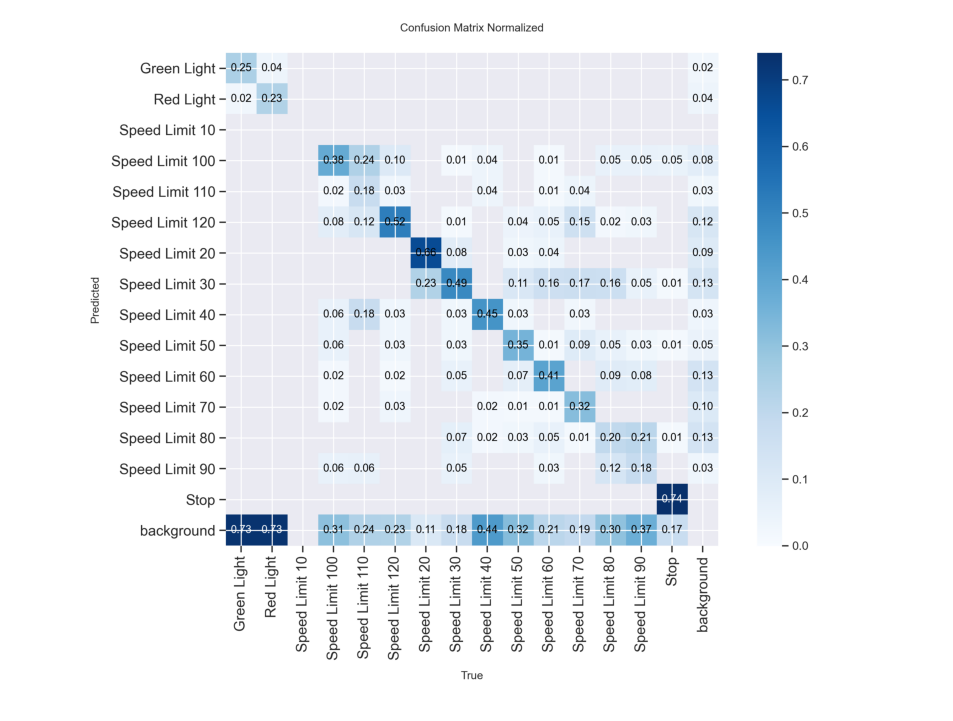

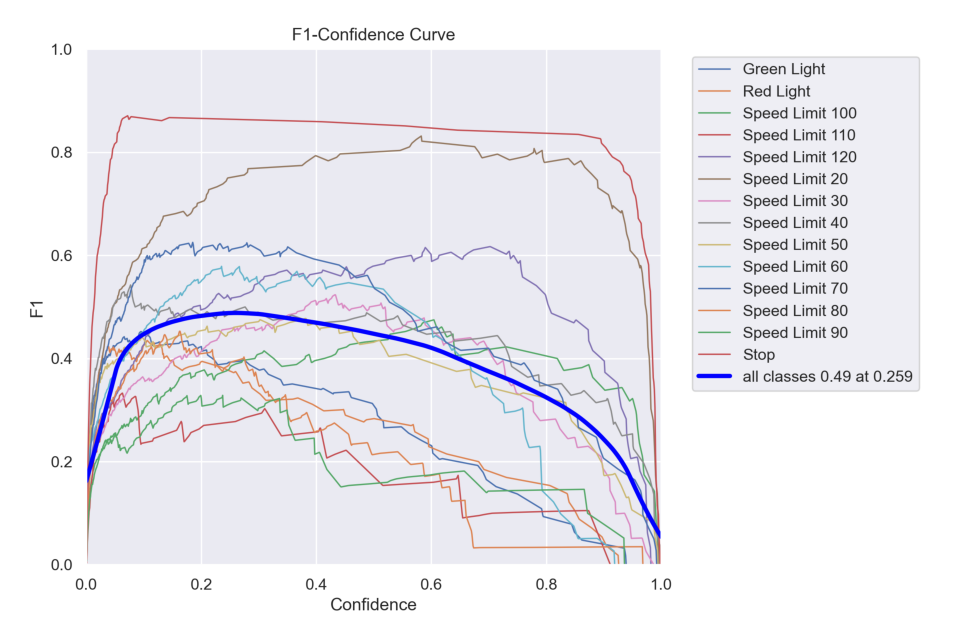

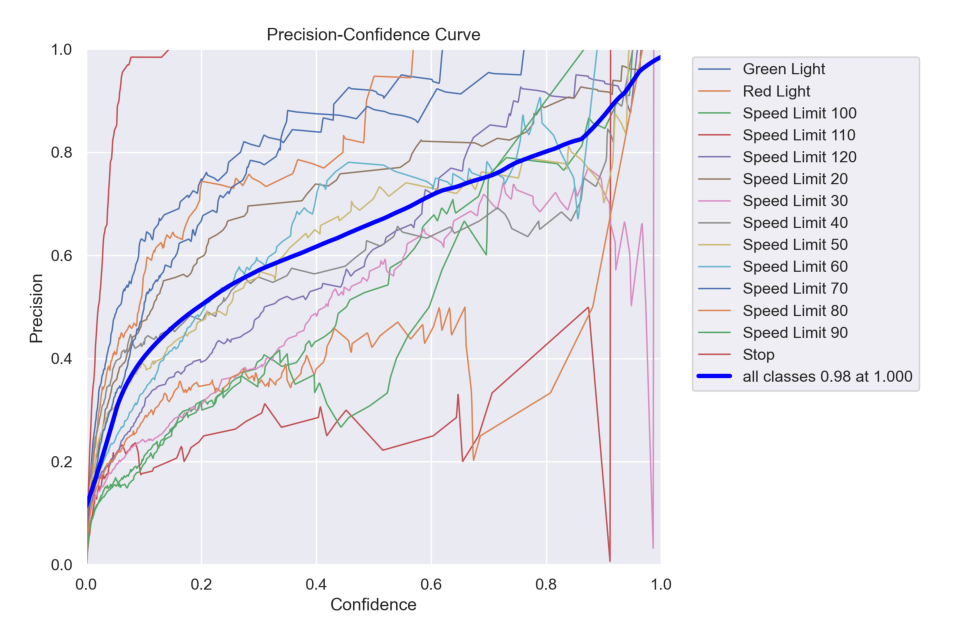

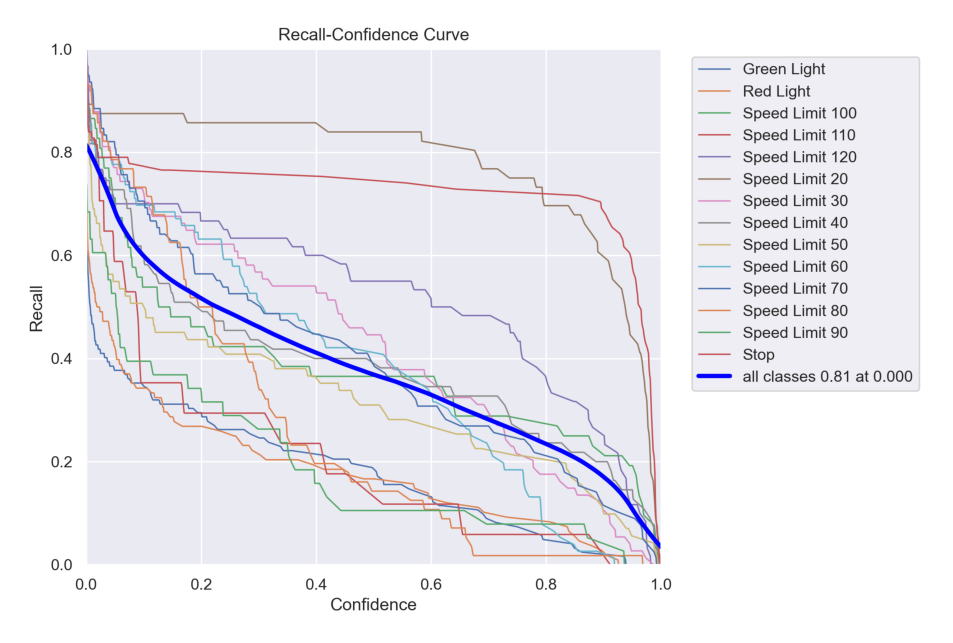

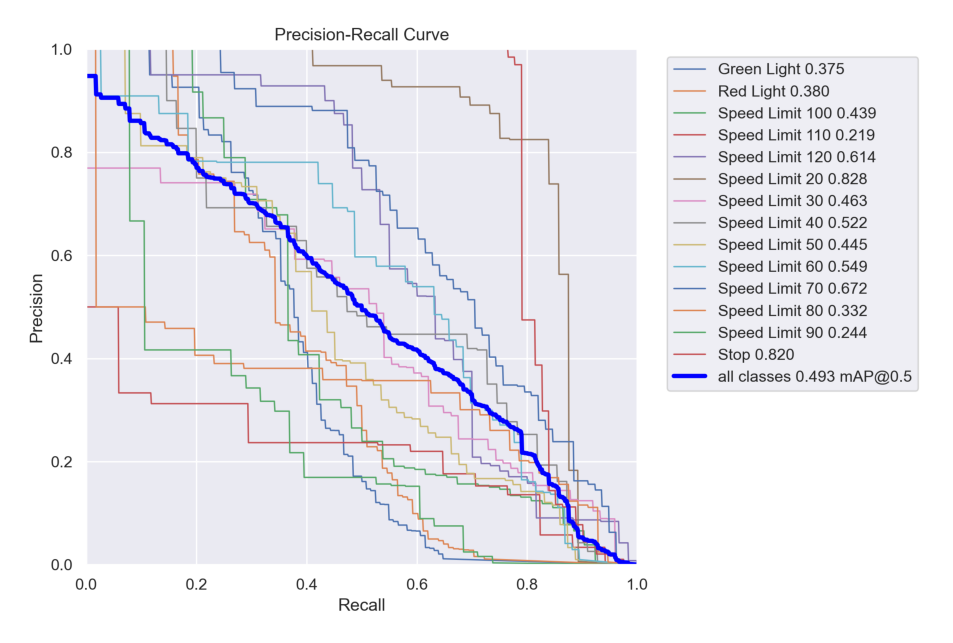

In [24]:

def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png'
]

# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","few_shot_val_1")

# Display the images
display_images(post_training_files_path, image_files)


## Loading the Best Performing Model

By default YOLO saves the best model weights in terms of mAP@0.5:0.95 and mAP@0.5

In [29]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","few_shot_training_1","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val',
                        name='few_shot_best_model')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 75.825.2 MB/s, size: 19.3 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\Traffic-Sign-Detection\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:07<00:00,  6.82it/s]


                   all        801        944      0.624      0.495      0.566      0.482
           Green Light         87        122      0.662      0.287      0.401       0.24
             Red Light         74        108      0.778      0.357      0.473      0.271
       Speed Limit 100         52         52      0.464      0.404      0.448      0.412
       Speed Limit 110         17         17      0.311      0.235      0.269      0.243
       Speed Limit 120         60         60      0.693       0.65      0.687      0.611
        Speed Limit 20         56         56      0.647      0.786      0.803      0.671
        Speed Limit 30         71         74      0.529      0.486      0.484      0.442
        Speed Limit 40         53         55      0.617      0.582      0.648      0.551
        Speed Limit 50         68         71      0.766      0.493       0.69      0.609
        Speed Limit 60         76         76      0.708      0.658      0.742      0.664
        Speed Limit 7

## Predictions on Test Images using best few shot model


0: 640x640 1 Speed Limit 30, 116.0ms
Speed: 43.8ms preprocess, 116.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 11.0ms
Speed: 5.6ms preprocess, 11.0ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 19.2ms
Speed: 4.9ms preprocess, 19.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Stop, 13.8ms
Speed: 4.2ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 70, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 

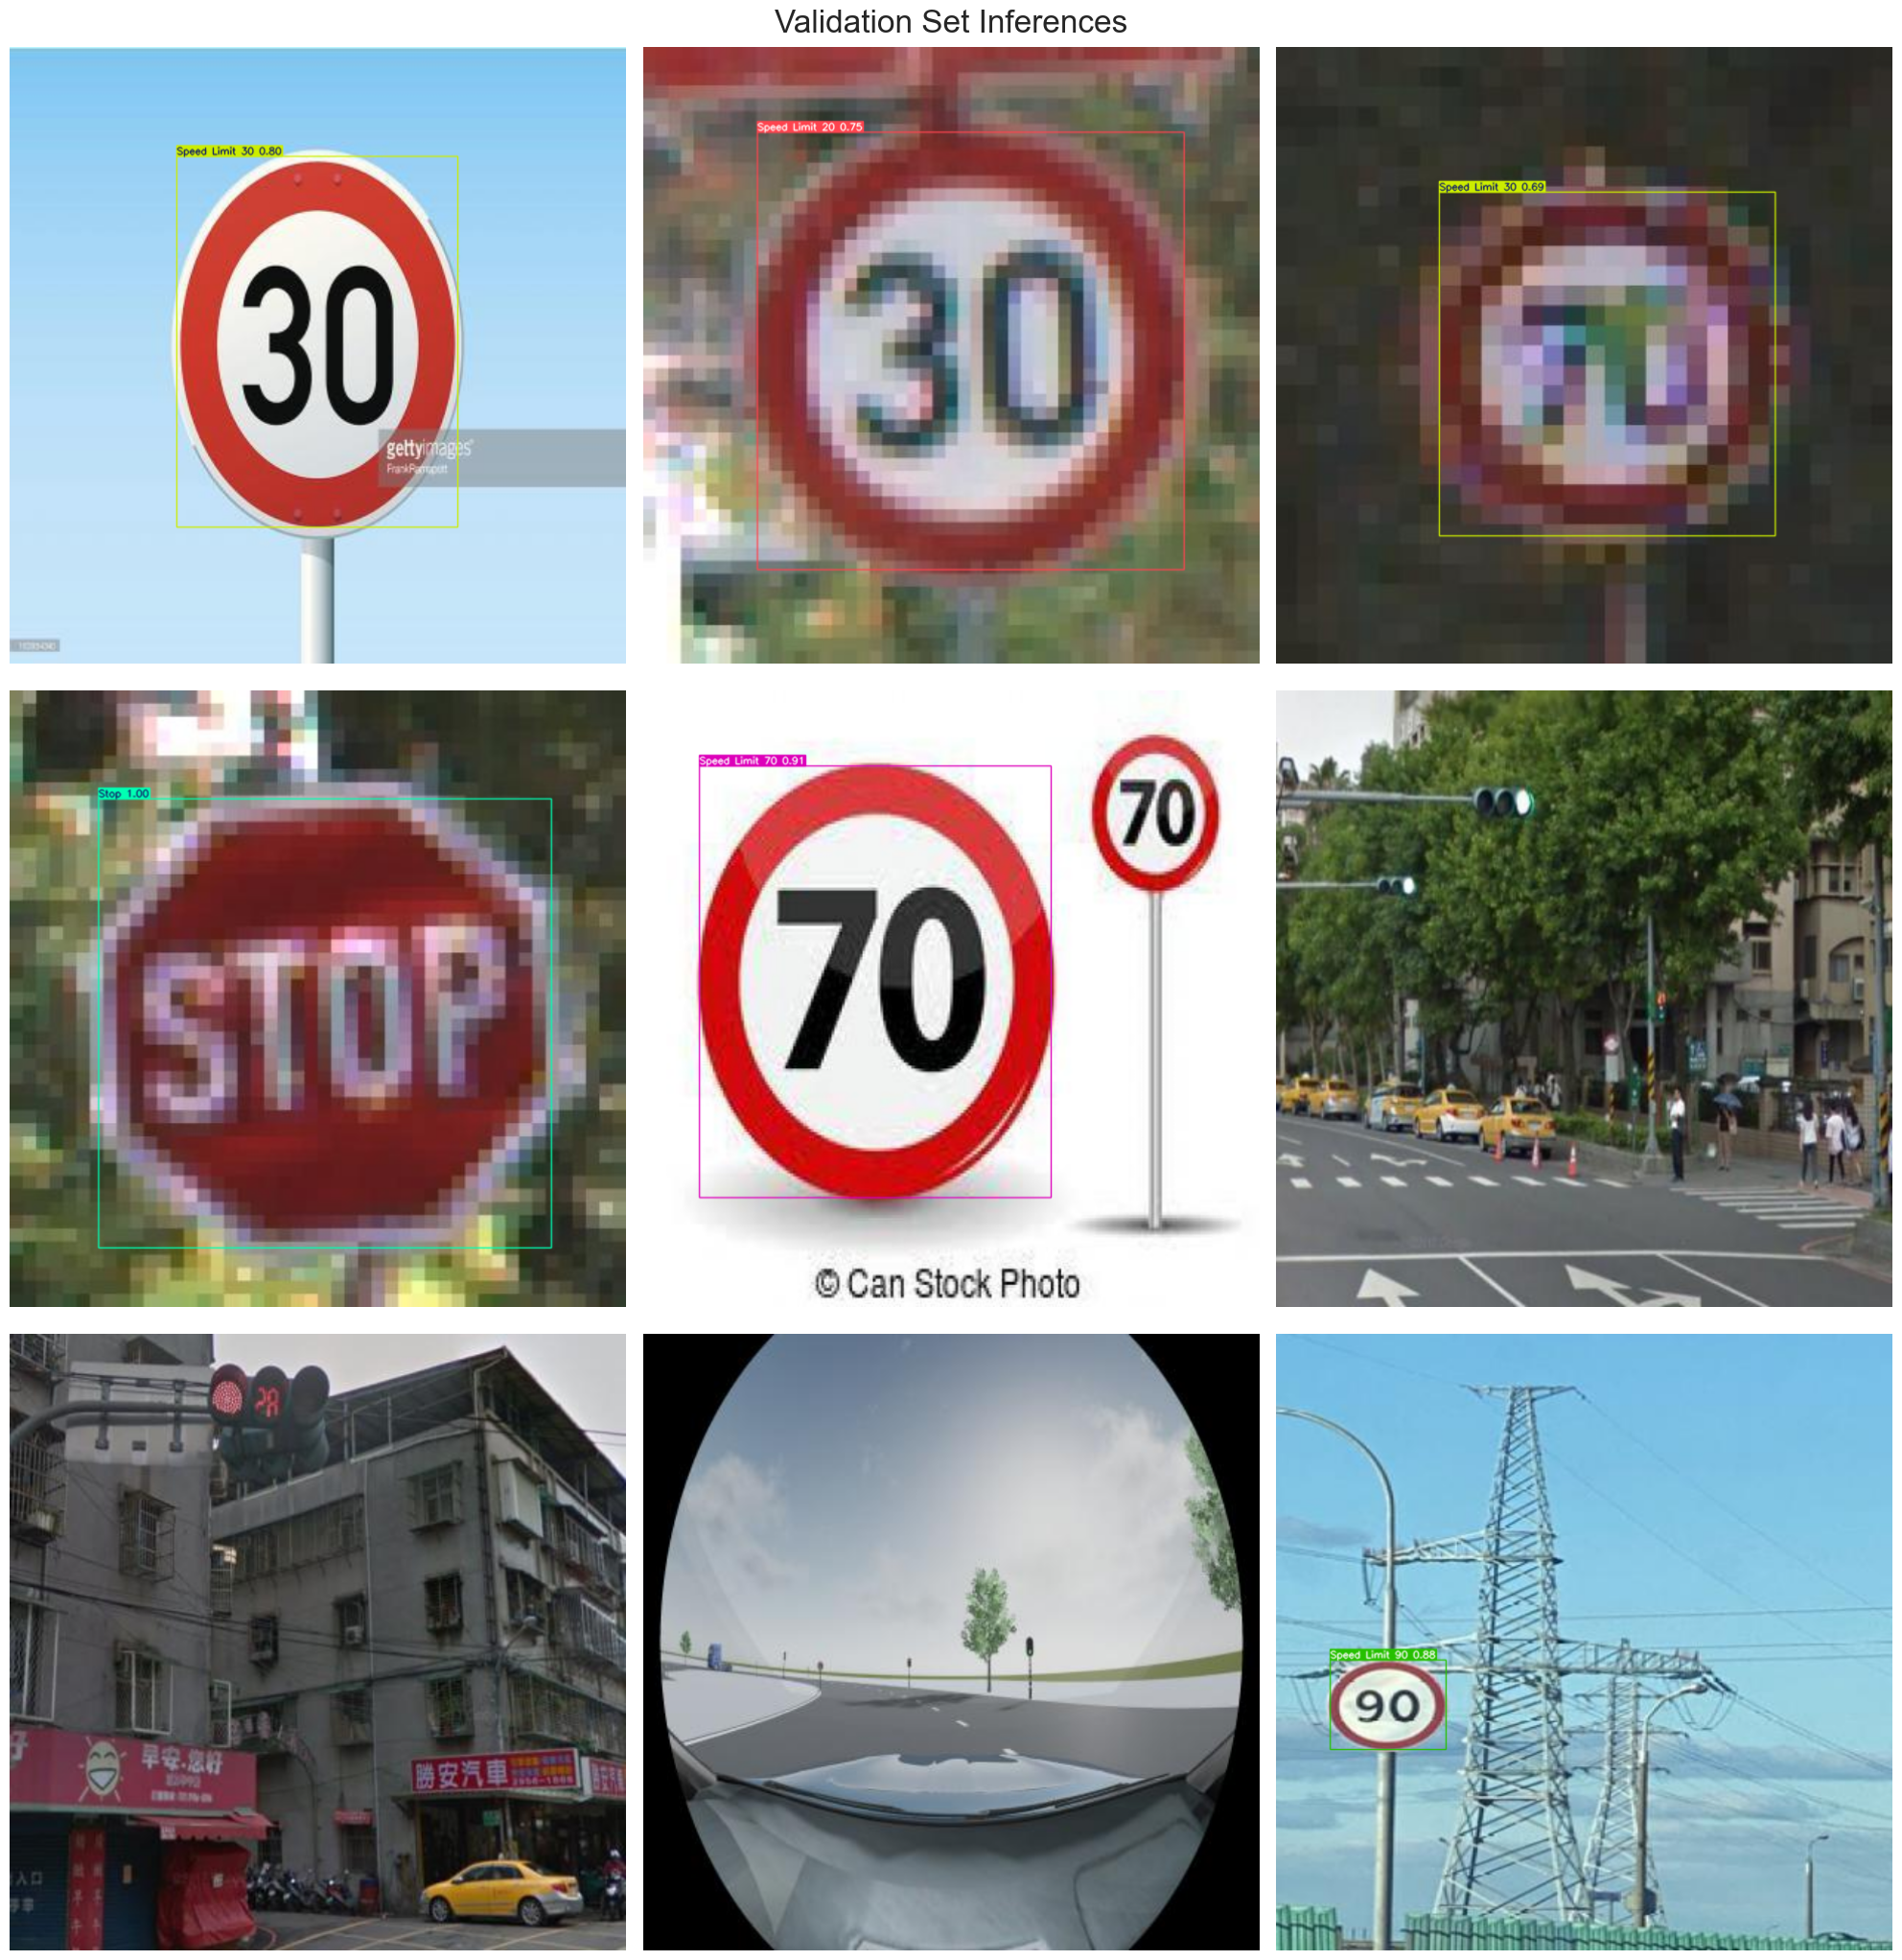

In [27]:
# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(640, 640)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = os.path.join(os.getcwd(), 'data')  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 9)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 21))
    fig.suptitle('Validation Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            
            # Load image
            image = cv2.imread(image_path)
            
            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(640, 640))
                # Normalize image
                normalized_image = normalize_image(resized_image)
                
                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
                
                # Predict with the model
                results = Valid_model.predict(source=normalized_image_uint8, imgsz=640, conf=0.5)
                
                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
